# Homework #4
Adarsh Mallya

## Problem 4.1
First, import all packages required:

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
import glob
import shutil

In [3]:
# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


The data is currently split based on their classifications, but we need to split them into train/test/validate splits:

In [5]:
src_dir = './images-2'

image_paths = []
labels = []

for category in os.listdir(src_dir):
    category_path = os.path.join(src_dir, category)
    if os.path.isdir(category_path):
        for img_path in glob.glob(os.path.join(category_path, '*')):
            image_paths.append(img_path)
            labels.append(category)

# create the train / temp split (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

# create the test / validate split (50% test, 50% validate)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

def copy_files(X, y, subset):
    for img_path, label in zip(X, y):
        dest_dir = os.path.join('./images2', subset, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, dest_dir)

copy_files(X_train, y_train, 'train')
copy_files(X_test, y_test, 'test')
copy_files(X_val, y_val, 'val')

## Problem 4.2
Implement the CNN!

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(80000, 128), 
            nn.ReLU(),
            nn.Linear(128, 5)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Problem 4.3

First, we need to create data loaders for each of the three datasets:

In [9]:
# define the training and testing mechanisms to load in images as datasets
BATCH_SIZE = 10

# define the transform 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 values for RGB
])

# first contruct the training set
train_dataset = datasets.ImageFolder(root=os.path.join('images2','train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# then the testing set
test_dataset = datasets.ImageFolder(root=os.path.join('images2','test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# then the validation set
val_dataset = datasets.ImageFolder(root=os.path.join('images2','val'), transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Next, we'll define a function to bundle up our training loop, but first we'll need to re-define our helper function to compute the correct number of labels:

In [8]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i] == 0:
            correct += 1
        total += 1
    return correct, total

Next, we will define our loss function (cross-entropy loss):

In [13]:
criterion = nn.CrossEntropyLoss()

Now we will define our training loop:

In [14]:
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    train_losses = []
    test_losses = []
    
    for epoch in range(NUM_EPOCHS):
        
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return train_losses, test_losses

Now we will train the model and visualize the performance.

In [15]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
NUM_EPOCHS = 30

train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/30 - Train Loss: 1.0436, Train Correct: 109/531 - Test Loss: 0.7669, Test Correct: 36/114 
Epoch 2/30 - Train Loss: 0.5764, Train Correct: 216/531 - Test Loss: 0.7041, Test Correct: 38/114 
Epoch 3/30 - Train Loss: 0.3603, Train Correct: 256/531 - Test Loss: 0.5754, Test Correct: 45/114 
Epoch 4/30 - Train Loss: 0.2532, Train Correct: 281/531 - Test Loss: 0.4945, Test Correct: 44/114 
Epoch 5/30 - Train Loss: 0.0616, Train Correct: 318/531 - Test Loss: 0.7152, Test Correct: 45/114 
Epoch 6/30 - Train Loss: 0.0133, Train Correct: 324/531 - Test Loss: 0.6426, Test Correct: 49/114 
Epoch 7/30 - Train Loss: 0.0043, Train Correct: 324/531 - Test Loss: 0.6350, Test Correct: 47/114 
Epoch 8/30 - Train Loss: 0.0020, Train Correct: 324/531 - Test Loss: 0.6838, Test Correct: 48/114 
Epoch 9/30 - Train Loss: 0.0011, Train Correct: 324/531 - Test Loss: 0.6960, Test Correct: 49/114 
Epoch 10/30 - Train Loss: 0.0009, Train Correct: 324/531 - Test Loss: 0.7043, Test Correct: 49/114 
Epoch 11/

## Problem 4.4

Let's plot the model's performance over time.

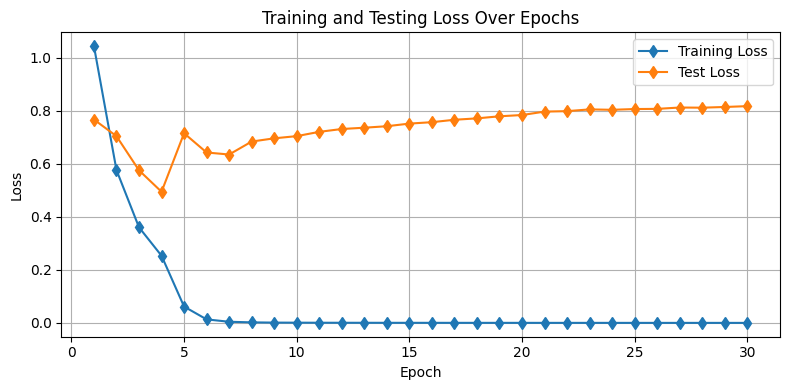

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This model is ridiculously overfitted. The test losses barely decreased at all while the train losses converged long before 30 epochs. To confirm this, we can visualize some of the predictions this model made.

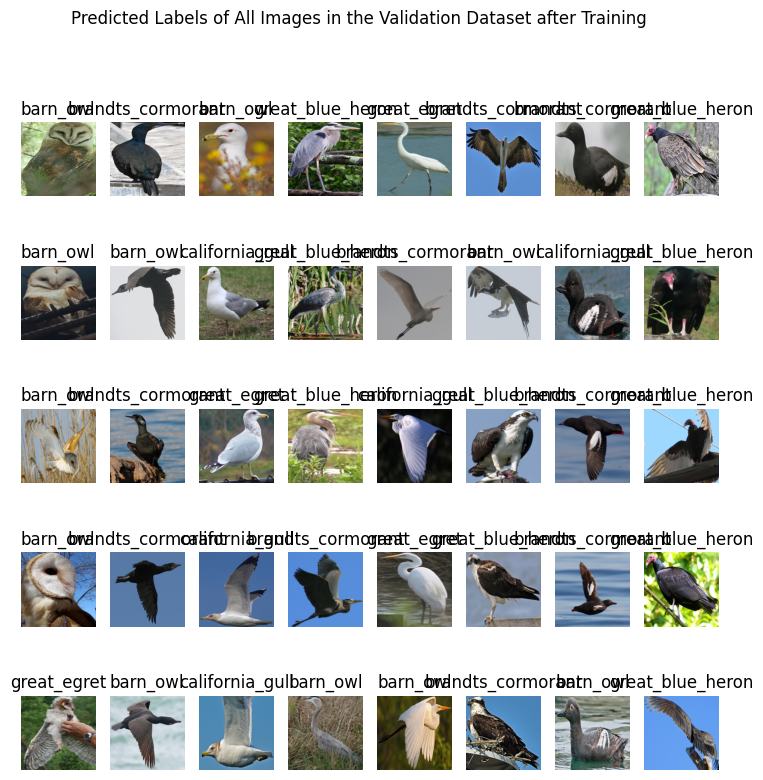

In [23]:
species = [
    'barn_owl',
    'brandts_cormorant',
    'california_gull',
    'great_blue_heron',
    'great_egret',
    'osprey',
    'pigeon_guillemot',
    'turkey_vulture'
]

model.eval()

# make a figure object
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(5, len(species))

# loop through each species (column)
for i, s in enumerate(species):

    # loop through the image files
    file_list = os.listdir(os.path.join('images2','val', str(s)))[:5]
    for file_count, file_name in enumerate(file_list):

        # load the image
        image = Image.open(os.path.join('images2','val',str(s),file_name)).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # get the predicted class
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = species[predicted.item()]

        # add the image to the plot with the prediction
        ax = fig.add_subplot(gs[file_count, i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(predicted_class)
        file_count += 1

plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
plt.show()

As we can see, the model is not accurate at all. Some predictions are correct, but there's clearly a disconnect in what the model is looking for. We can try adding a dropout layer to optimize the model's performance.

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(80000, 128), 
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [25]:
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 30

train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/30 - Train Loss: 1.1231, Train Correct: 75/531 - Test Loss: 0.8482, Test Correct: 25/114 
Epoch 2/30 - Train Loss: 0.9160, Train Correct: 119/531 - Test Loss: 0.7483, Test Correct: 30/114 
Epoch 3/30 - Train Loss: 0.8440, Train Correct: 148/531 - Test Loss: 0.7296, Test Correct: 38/114 
Epoch 4/30 - Train Loss: 0.7877, Train Correct: 149/531 - Test Loss: 0.6991, Test Correct: 38/114 
Epoch 5/30 - Train Loss: 0.7282, Train Correct: 159/531 - Test Loss: 0.6636, Test Correct: 38/114 
Epoch 6/30 - Train Loss: 0.7086, Train Correct: 190/531 - Test Loss: 0.6967, Test Correct: 34/114 
Epoch 7/30 - Train Loss: 0.7089, Train Correct: 198/531 - Test Loss: 0.6035, Test Correct: 40/114 
Epoch 8/30 - Train Loss: 0.6272, Train Correct: 194/531 - Test Loss: 0.5853, Test Correct: 44/114 
Epoch 9/30 - Train Loss: 0.5375, Train Correct: 225/531 - Test Loss: 0.5606, Test Correct: 48/114 
Epoch 10/30 - Train Loss: 0.4382, Train Correct: 227/531 - Test Loss: 0.6311, Test Correct: 43/114 
Epoch 11/3

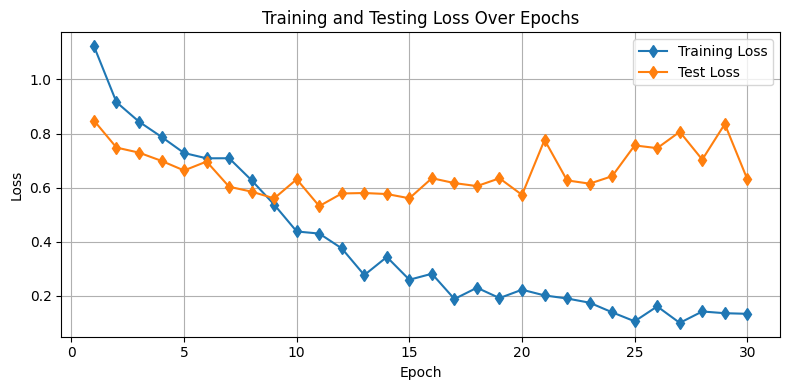

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This model was much more accurate! While the test losses were still rather high for what we would like, it was greatly improved with the addition of a dropout layer. We can again visualize some of the predictions made on the validation set:

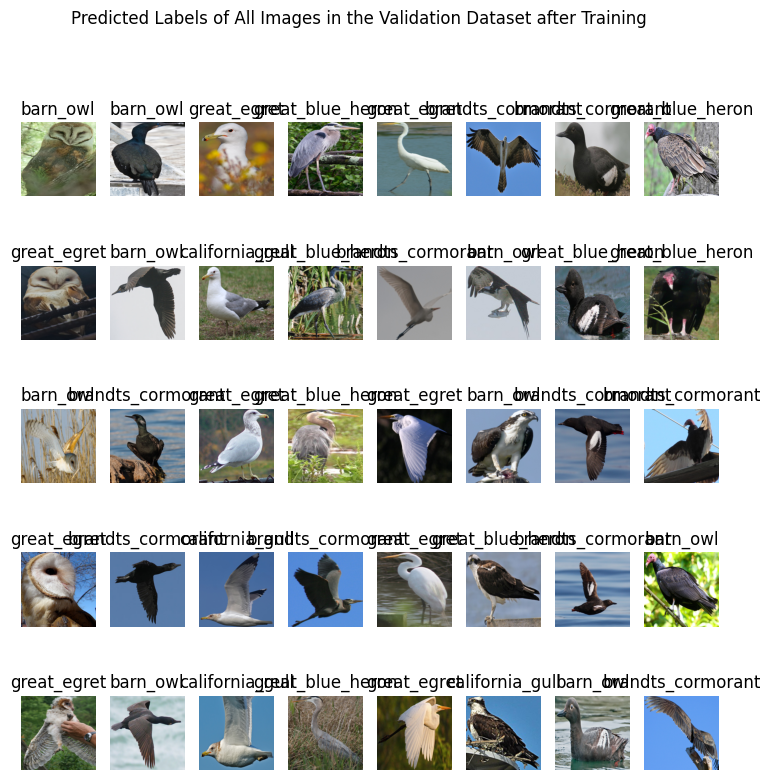

In [27]:
species = [
    'barn_owl',
    'brandts_cormorant',
    'california_gull',
    'great_blue_heron',
    'great_egret',
    'osprey',
    'pigeon_guillemot',
    'turkey_vulture'
]

model.eval()

# make a figure object
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(5, len(species))

# loop through each species (column)
for i, s in enumerate(species):

    # loop through the image files
    file_list = os.listdir(os.path.join('images2','val', str(s)))[:5]
    for file_count, file_name in enumerate(file_list):

        # load the image
        image = Image.open(os.path.join('images2','val',str(s),file_name)).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # get the predicted class
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = species[predicted.item()]

        # add the image to the plot with the prediction
        ax = fig.add_subplot(gs[file_count, i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(predicted_class)
        file_count += 1

plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
plt.show()

We're doing a lot better here.

## Problem 4.5

My approach with constructing the CNN was quite simple. I started by building the most common CNN framework, using two linear layers the ReLU activation function. This baseline model's performance was highly inadequate, as it was highly overfitted and failed to improve its test losses over time. In order to lessen the overfitting problem, I decided to add a dropout layer, which was something we did in the lecture that helped to reduce overfitting. And this worked! The accuracy of the modified model was much better than the baseline. I think one reason that misclassifications might have been made was because so many of the bird species are similarly built and have similar colors, meaning the model likely confused some of the species with each other.